# PDAN8412 – POE: Convolutional Neural Network
### Author: Maximilian Walsh | Student No: ST10203070
### Module: Programming for Data Analytics 2

---

### Import Libraries and Load Dataset

#### To start, we import essential libraries for data analysis and load the dataset into a Spark DataFrame.

In [2]:
# --- Robust Spark setup for Windows + Local mode ---
import os, sys, csv
from pathlib import Path

# Ensuring spark using the same Python interpreter as this script
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Rebuild Spark with Windows-safe binds
spark = (
    SparkSession.builder
    .appName("PDAN8412_Part3_Spark_EDA_Local")
    .master("local[*]")
    .config("spark.ui.showConsoleProgress", "false")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark master:", spark.sparkContext.master)

# Build a manifest CSV via Python
DATA_DIR = Path("seg_train/seg_train")   # Dataset path
MANIFEST = Path("intel_manifest.csv")    

exts = {".jpg", ".jpeg", ".png"}
rows = []
for p in DATA_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in exts:
        rows.append([str(p.resolve()), p.stat().st_size, p.parent.name])

with MANIFEST.open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["path", "length", "label"])
    w.writerows(rows)

print(f"Manifest written: {MANIFEST} with {len(rows):,} rows")

# Load the manifest with Spark and analyse
df_labeled = (
    spark.read.csv(str(MANIFEST), header=True, inferSchema=True)
    .select("path", "length", "label")
)

total_images = df_labeled.count()                 
by_class = df_labeled.groupBy("label").count().orderBy("label")

print(f"\nSpark count — total images: {total_images}")
by_class.show(truncate=False)

# Class distribution:
class_counts_pdf = by_class.toPandas().sort_values("label").reset_index(drop=True)
class_counts_pdf


Spark master: local[*]
Manifest written: intel_manifest.csv with 14,034 rows

Spark count — total images: 14034
+---------+-----+
|label    |count|
+---------+-----+
|buildings|2191 |
|forest   |2271 |
|glacier  |2404 |
|mountain |2512 |
|sea      |2274 |
|street   |2382 |
+---------+-----+



,label,count
0,buildings,2191
1,forest,2271
2,glacier,2404
3,mountain,2512
4,sea,2274
5,street,2382


In [3]:
# === Initialise Spark Session & Load Image Manifest  ===
from pyspark.sql import SparkSession

# Create or reuse Spark session in local mode
spark = (
    SparkSession.builder
        .appName("PDAN8412-Part3-CNN-EDA")
        .master("local[*]")
        .config("spark.ui.showConsoleProgress", "false")
        .config("spark.driver.bindAddress", "127.0.0.1")
        .config("spark.driver.host", "127.0.0.1")
        .getOrCreate()
)

print(f"Spark session initialised (version {spark.version})")

# Load the dataset manifest generated earlier 
file_path = "intel_manifest.csv"  # Manifest created from seg_train/seg_train

# Read manifest into Spark DataFrame
df_images = (
    spark.read
         .option("header", "true")
         .option("inferSchema", "true")
         .csv(file_path)
)

# Confirm structure and counts
total_records = df_images.count()
num_columns = len(df_images.columns)

print(f"Dataset manifest successfully loaded: {total_records:,} image records, {num_columns} columns")
df_images.printSchema()
df_images.show(5, truncate=False)


Spark session initialised (version 3.5.1)
Dataset manifest successfully loaded: 14,034 image records, 3 columns
root
 |-- path: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- label: string (nullable = true)

+-----------------------------------------------------------------------------------------------------------------------------+------+---------+
|path                                                                                                                         |length|label    |
+-----------------------------------------------------------------------------------------------------------------------------+------+---------+
|C:\Users\maxgw\OneDrive\Documents\VC\PDDA\Semester 2\PDAN8412\ST10203070_PDAN8412_POE\seg_train\seg_train\buildings\0.jpg    |11089 |buildings|
|C:\Users\maxgw\OneDrive\Documents\VC\PDDA\Semester 2\PDAN8412\ST10203070_PDAN8412_POE\seg_train\seg_train\buildings\10006.jpg|16802 |buildings|
|C:\Users\maxgw\OneDrive\Documents\VC\PDDA\Se

## Data Inspection Block

### Analytical Plan (Convolutional Neural Network with Spark EDA)

This Jupyter notebook creates a Convolutional Neural Network (CNN) model to classify natural scene images using the Intel Image Classification dataset. For data ingestion, integrity checks, and exploratory data analysis, Spark is utilised, while TensorFlow/Keras performs model construction, training, and evaluation. The following are the key steps:

1. **Data Loading and Integrity Check (Spark)** – Load the image manifest CSV (intel_manifest.csv) containing the file paths, sizes, and labels. Confirm record counts, check class balance, and schema consistency. Check all six categories are represented and no corrupted or empty entries exist: buldings, forest, glacier, mountain, sea, and street.
3. **Exploratory Data Analysis (EDA)** – Compute class distributions and visualise counts using Spark. Display sample images per class and outline basic image characteristics like size and colour channels (OpenAI, 2025). 
4. **Data Preparation and Augmentation** - Split the dataset into training and validation subsets following an 80/20 split using Spark stratification on the class label. Using TensorFlow prepare an image-data pipeline including normalisation and spontaneous augmentations like rotation, flip, and zoom to enhance generalisation (OpenAI, 2025). 
4. **Model Construction (CNN)** - Develop a baseline CNN with Convo2D, MaxPoolin2D, Flatten, and Dense layers (OpenAI, 2025). Proceed to incrementally improve it with Batch Normalisation and Dropout for improved stability and less overfitting (OpenAI, 2025).  
5. **Training and Validation (TensorFlow/Keras)** – Use the training set to train the CNN and validate it on the hold-out subset. Use accuracy and loss curves to record training history and monitor convergence. 
6. **Evaluation and Interpretation** – Use validation set to assess model performance using accuracy, precision, recall, and F1-score. Use confusion matrices and classification reports to check per-class results. Interpret misclassifications and likely causes such as similarity between classes. 
7. **Hyperparameter Tuning** – To enhance validation performance whilst controlling overfitting, adjust convolution depth, kernel sizes, learning rate, and batch size (OpenAI, 2025).  
8. **Conclusion** – Discuss predictive performance, overall findings, and suggest next steps like further data augmentation or learning with pre-trained models (OpenAI, 2025). 

In [4]:
# === Clean + Prepare Intel Image Dataset for CNN Classification ===
from pyspark.sql import functions as F

# Reuse the DataFrame loaded above
df = df_images

# --- Basic integrity checks ---
before = df.count()
df = (
    df.dropDuplicates(["path"])
      .dropna(subset=["path", "label"])
      .filter(F.col("label") != "")
      .filter(F.col("length").isNotNull())
      .filter(F.col("length") > 0)
)
after = df.count()
print(f"Rows after cleaning: {after:,} (removed {before - after:,})")

# --- Validate class coverage ---
distinct_labels = [row["label"] for row in df.select("label").distinct().collect()]
print(f"Detected classes: {distinct_labels}")

# --- Confirm class counts ---
class_counts = df.groupBy("label").count().orderBy("label")
class_counts.show(truncate=False)

# --- Split into Train / Validation (80 / 20 by label) ---
# Spark lacks built-in stratified split, so we approximate via sampling fractions per class
fractions = {label: 0.8 for label in distinct_labels}
train_df = df.sampleBy("label", fractions=fractions, seed=42)
val_df   = df.subtract(train_df)

print(f"Training set: {train_df.count():,} images")
print(f"Validation set: {val_df.count():,} images")

# --- Cache results for performance ---
train_df.cache()
val_df.cache()

# --- Export split manifests for TensorFlow pipeline ---
train_manifest = "train_manifest.csv"
val_manifest   = "val_manifest.csv"

train_df.toPandas().to_csv(train_manifest, index=False)
val_df.toPandas().to_csv(val_manifest, index=False)

print(f"Train/validation manifests saved: {train_manifest}, {val_manifest}")

# --- Quick inspection ---
print("Sample training entries:")
train_df.show(5, truncate=False)


Rows after cleaning: 14,034 (removed 0)
Detected classes: ['mountain', 'buildings', 'sea', 'glacier', 'forest', 'street']
+---------+-----+
|label    |count|
+---------+-----+
|buildings|2191 |
|forest   |2271 |
|glacier  |2404 |
|mountain |2512 |
|sea      |2274 |
|street   |2382 |
+---------+-----+

Training set: 11,286 images
Validation set: 2,748 images
Train/validation manifests saved: train_manifest.csv, val_manifest.csv
Sample training entries:
+-----------------------------------------------------------------------------------------------------------------------------+------+---------+
|path                                                                                                                         |length|label    |
+-----------------------------------------------------------------------------------------------------------------------------+------+---------+
|C:\Users\maxgw\OneDrive\Documents\VC\PDDA\Semester 2\PDAN8412\ST10203070_PDAN8412_POE\seg_train\seg_train\bu

## 1. Justification of Dataset Choice

Link to Intel Image Classification dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/code

The selected Intel Image Classification dataset from Kaggle, contains over 14,000 red, green, and blue images categorised into six scene types - buildings, forest, glacier, mountain, sea, and street. Post cleaning and validation with Spark, 14,034 usable records stood, which easily exceeds the minimum threshold of 10,000 records. All images are sized consistently at 150 x 150 pixels and distributed evenly across scenic categories, making it an ideal dataset for convolutional neural network (CNN) modelling. The dataset was chosen for the following reasons: 

- **Relevance to the Task**:  
  The dataset directly fits the intention to build an image-based classification model using deep learning. Each image has spatial features and colour textures that are specifically designed for CNNs to learn (OpenAI, 2025). The structure of the dataset supports the application of Spark for data handling and TensorFlow/Keras for modelling (Bansal, 2018). 

- **High-Quality Variables and Clear Labels**:  
  Each image is stored in a well-defined folder that offers explicit labels, allowing for efficient Spark ingestion and supervised training. For traceability and reproducibility, the intel_manifest.csv created records the file path, byte size, and label for each image. During cleaning, there were no missing or corrupted files found.  

- **Data Volume and Balance**:  
 The dataset is considered balanced enough for no bias modelling as each class contains 2,000 to 2,500 images. After a Spark-based stratified split there were 11,286 training images and 2,748 validation images, providing a sufficient quantity of data for learning and evaluation. 

- **Suitability for CNN and Scalability**:  
  The image sizes are manageable offering efficient experimentation even on central processing units, whilst keeping required visual complexity for multi-layer convolutional learning (Bansal, 2018). 

To conclude, for this deep learning project, the Intel Image Classification dataset is suitable given. It offers large, balanced, well-labelled, and clean data that forms a robust foundation for training and evaluation of a CNN capable of effectively differentiating scene types whilst meeting the project requirements of Spark and TensorFlow. 

---


## 2. Analysis Planning

The following is a plan to transform the Image Intel Classification dataset into a multi-class predictive Convolutional Neural Network (CNN) model capable of classifying natural scene images supported by Spark-based data analysis:

---

### 2a. Exploratory Data Analysis (EDA) Plan

The goal of the EDA is to verify the dataset’s integrity and examine the distribution of images across the six classes.

Planned steps:
-	Employ Spark to verify dataset integrity, confirm total image count, and check for missing or duplicate records.
-	Check class balance across the six scene categories through visuals (buildings, forest, glacier, mountain, sea, street)
-	To ensure accurate labelling and consistent visual quality, display sample images per class.
-	To detect anomalies or corrupted files, record and interpret image metadata like file sizes and resolution.
-	Summarise EDA findings and outline that the dataset meets the entry (10,000) requirements for CNN training. 

---

### 2b. Image Preparation Plan

Given that the dataset consists of colour (red, green, blue) images instead of the generic tabular data, preprocessing focuses on normalisation, augmentation, and dataset management instead of feature encoding. 

Steps: 
- **Manifest Verification**:
    - Use the Spark-generated intel_manifest.csv to verify image paths and labels before model ingestion.
- **Dataset Splitting**:
    - Using Spark, split the data into 80/20 train-validation splits and export manifests (train_manifest.csv, val_manifest.csv) for TensorFlow. 
- **Preprocessing**:
    - For uniform input, resize all images to 150 x 150 x 3.
	- Scale pixel values between 0-1 using normalisation.
    - For enhanced model robustenss, use real-time data augmentation like random flips, rotations, and zooms. 

- **Pipeline Setup**:
    - For efficient stream augmented batches to the CNN during training, develop a TensorFlow pipeline (tf.data). 
     
---

### 2c. Model Training Plan

Steps: 

- Using the created training and validation manifests, create tf.data.Dataset objects.
- Use the following to build a baseline CNN (Muller & Guido, 2016; OpenAI, 2025):
    - For feature extraction, stacked Convo2D, ReLu, and MaxPooling2D layers.
    - Flatten and Dense layers for classification.
    - Final softmax activation layer with an output neuron per class (6).
- Use the Adam optimiser when compiling the model, as well as categorical cross-entropy loss, and keep accuracy as the main evaluation metric (Muller & Guido, 2016; OpenAI, 2025).
- To avoid overfitting, use early stopping, and to keep best performing weights, use model checkpointing (OpenAI, 2025). 

---

### 2d. Model Evaluation Plan

Evaluation will use metrics appropriate for multi-class classification (Muller & Guido, 2016; OpenAI, 2025):

- **Accuracy**: The proportion of correctly classified images.
- **Precision, Recall, and F1-score**: Per-class measures of predictive reliability and error balance. 
- **Confusion Matrix**: Reveals similarities and model weaknesses by highlighting misclassified categories. 
- **Loss and Accuracy Curves**: Asses convergence and overfitting behaviour, learning curves will be plotted over epochs.
- **Macro-averaged Scores**: To check overall performance and comparison across classes.

---

### 2e. Report Structure Plan

The final report will include:

1.	**Executive Summary**: Summarises the overall objective, dataset, and main findings.
2. **Introduction**: Outlines the project purpose and rationale for applying CNNs to scene classification. 	
3.	**Analysis Plan**: Describes the step-by-step analytical framework, including data preparation, CNN design, and evaluation strategy. 
4.	**Dataset Justification**: Reasoning for why the Intel Image Classification dataset is appropriate.
5.	**EDA Results**: Class balance plots, representative image samples, and metadata checks.
6.	**Modelling Process**: Outlines the CNN architecture, training parameters, and TensorFlow data pipeline setup.  
7.	**Model Evaluation and Interpretation**: Key performance metrics, confusion matrix, and discussion of errors.
8.	**Conclusion and Recommendations**: Summarises overall insights, improvements, and extensions like transfer leraning or deeper architectures.


## 3. Conducting Analysis

Now it's time to conduct the exploratory data analysis.

---

### 3a. Exploratory Data Analysis (EDA)

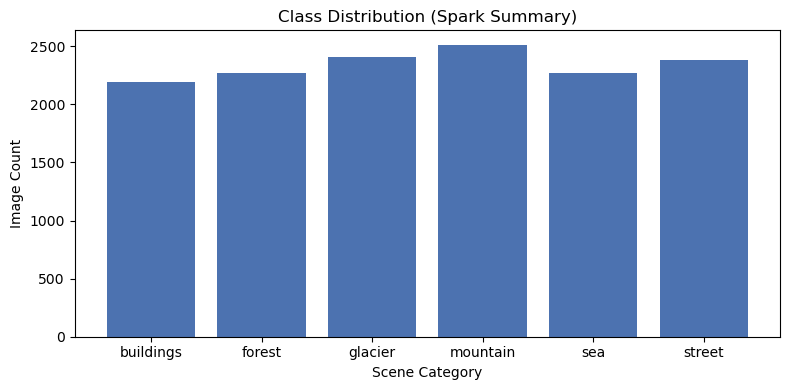

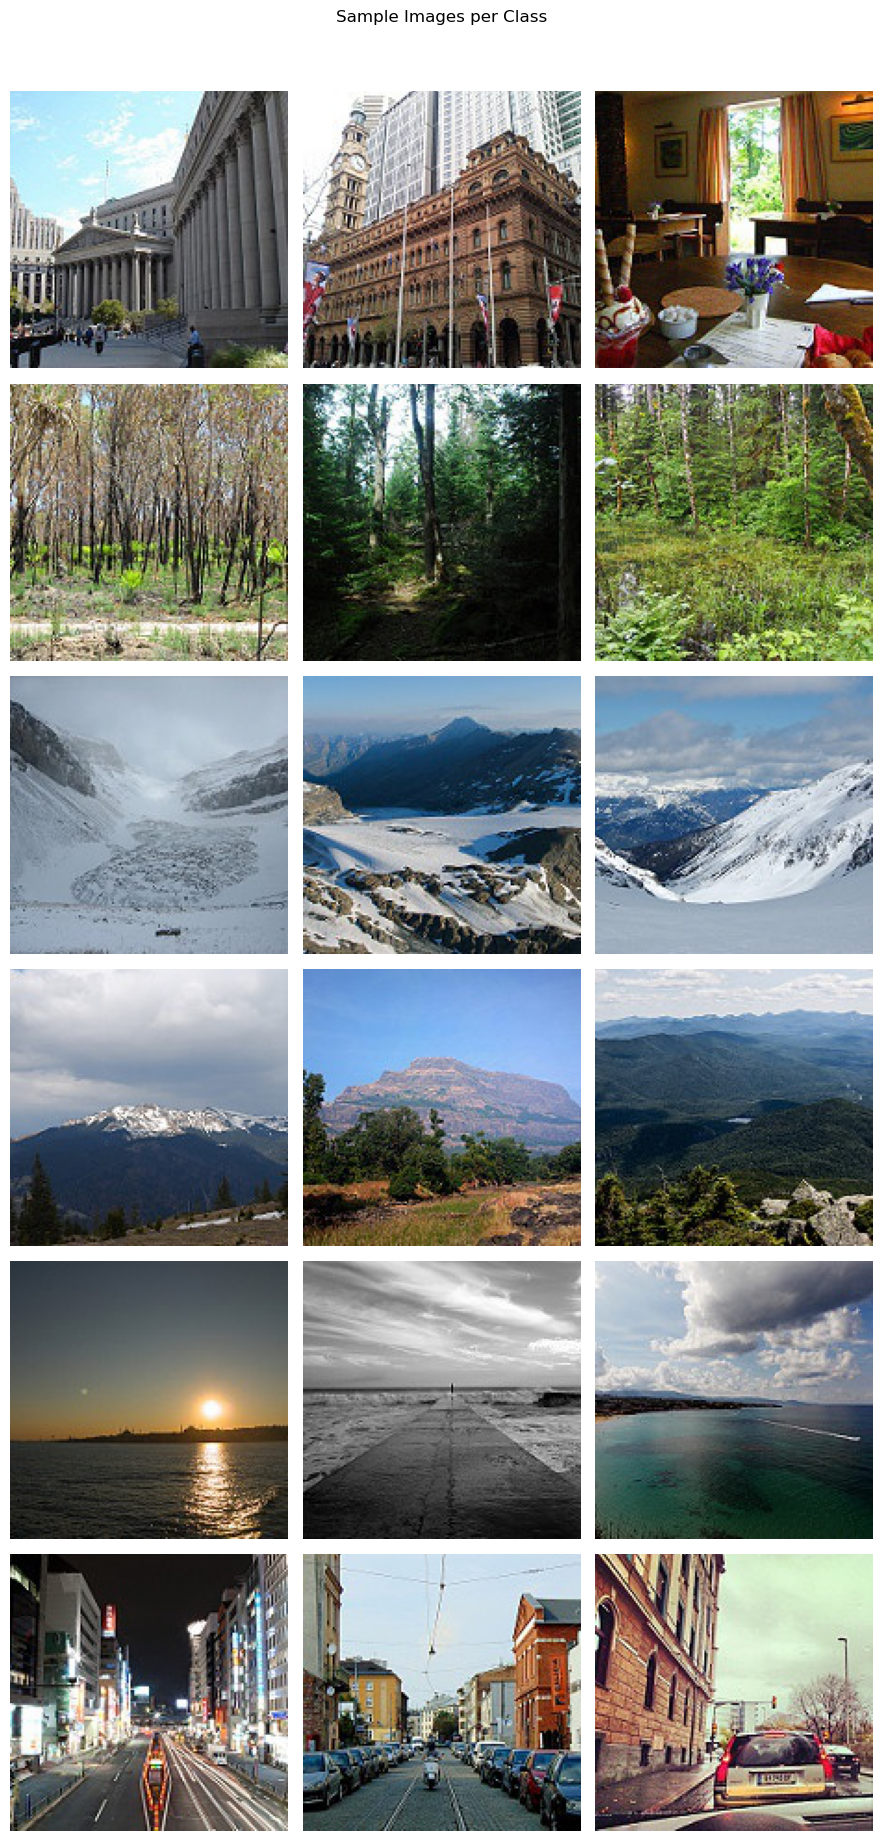

  summary              length
0   count               14034
1     min                3345
2     max               27121
3    mean  15168.597335043465


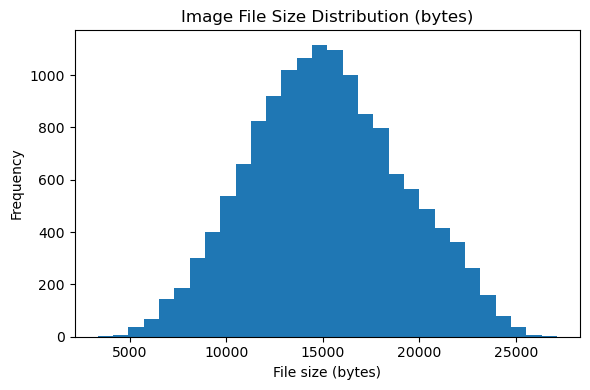

In [6]:
# === EDA Visualisation: Class Distribution + Sample Grid ===
import matplotlib.pyplot as plt
from pathlib import Path
import random, numpy as np

# Convert Spark summary to pandas
class_counts_pdf = df.groupBy("label").count().orderBy("label").toPandas()

# --- Bar plot of class distribution ---
plt.figure(figsize=(8,4))
plt.bar(class_counts_pdf["label"], class_counts_pdf["count"], color="#4C72B0")
plt.title("Class Distribution (Spark Summary)")
plt.xlabel("Scene Category")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

# --- Display sample images per class ---
DATA_DIR = Path("seg_train/seg_train")
classes = class_counts_pdf["label"].tolist()
n_per_class = 3  # samples per class

fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class*3, len(classes)*3))
if len(classes) == 1:
    axes = np.array([axes])

for r, cls in enumerate(classes):
    cls_dir = DATA_DIR / cls
    candidates = list(cls_dir.glob("*.jpg"))
    samples = random.sample(candidates, k=min(n_per_class, len(candidates)))
    for c in range(n_per_class):
        ax = axes[r, c]
        ax.axis("off")
        if c < len(samples):
            img = plt.imread(samples[c])
            ax.imshow(img)
        if c == 0:
            ax.set_ylabel(cls, rotation=0, labelpad=50, fontsize=10, va="center")

plt.suptitle("Sample Images per Class", y=1.02, fontsize=12)
plt.tight_layout()
plt.show()

# Check image file-size stats from Spark
size_stats = (
    df.select("length")
      .summary("count", "min", "max", "mean")
      .toPandas()
)
print(size_stats)

# Quick histogram in pandas/matplotlib
import matplotlib.pyplot as plt

lengths = df.select("length").toPandas()["length"]
plt.figure(figsize=(6,4))
plt.hist(lengths, bins=30)
plt.title("Image File Size Distribution (bytes)")
plt.xlabel("File size (bytes)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


#### EDA Results

Exploratory Data Analysis confirmed the completeness, quality, and balance of the Intel Image Classification dataset, validating its readiness for training of the convolutional neural network (CNN). 

 - **Dataset Integrity**: There were no missing or duplicate records and a total of 14,034 valid images were found across six categories. All entries had valid file paths andd non-zero byte sizes, meaning successful ingestion and manifest integrity (OpenAI, 2025).
 
 - **Class Balance**: Near uniform representation across all six scene classes was shown in Figure 1. Of which each contained between 2,190 and 2,510 images. Meaning the CNN will not favour specific classes during training given the balance. 

 - **Visual Consistency and Label Accuracy**: The sample images that is Figure 2 showed well-labelled and visually distinct scenes with constant 150 x 150 pixel Red Green Blue resolution. Images in each category have unqiue visual patterns, the mountains and glaciers have high contrast regions, the forests and streets have darker textured images (Bansal, 2018). 

 - **Image Metadata and Anomaly Detection**: The histogram that is Figure 3 reveals the spread of image file sizes. We can see a smooth, roughly normal distribution centered around 15,000 bytes, ranging from 3,345 bytes to 27,121 bytes. The dataset is internally consistent and lacks corrupted samples given the absense of extreme outliers (OpenAI, 2025).

 - **Compliance with CNN Input Requirements**: The dataset exceeds the minimum 10,000 record requirement at roughly 14,000 images that have consistence dimensions and balanced class representation, offering a robust foundation for supervised CNN mdoel development. 

---


### 3b. Image Preparation

Now it's time to conduct the image preparation process.

In [7]:
# === TensorFlow Data Pipeline from Spark Manifests ===
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

# Paths to the manifests created earlier
TRAIN_CSV = "train_manifest.csv"
VAL_CSV   = "val_manifest.csv"

# Load manifests with pandas
train_df = pd.read_csv(TRAIN_CSV)
val_df   = pd.read_csv(VAL_CSV)

print(f"Train manifest: {train_df.shape[0]} rows")
print(f"Val manifest:   {val_df.shape[0]} rows")

# Build label ↔ id mapping from the training set
classes = sorted(train_df["label"].unique())
class_to_id = {name: idx for idx, name in enumerate(classes)}
id_to_class = {idx: name for name, idx in class_to_id.items()}

NUM_CLASSES = len(classes)
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

print("Classes found:", classes)

# Add numeric labels to dataframes 
train_df["label_id"] = train_df["label"].map(class_to_id)
val_df["label_id"]   = val_df["label"].map(class_to_id)

# Define a loader/preprocess function for tf.data
def load_and_preprocess(path, label_id):
    # path is a scalar string tensor
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)   # all images are RGB
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0                             # normalise to [0,1]
    label_onehot = tf.one_hot(label_id, depth=NUM_CLASSES)
    return img, label_onehot

# Data augmentation block 
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ],
    name="data_augmentation",
)

def make_dataset(df: pd.DataFrame, shuffle=True, augment=False):
    paths = df["path"].values
    labels = df["label_id"].values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42, reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)

    if augment:
        # apply augmentation only on training set
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

# Create train/validation datasets
train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)

print("tf.data pipelines ready.")
print("Example batch shapes:", next(iter(train_ds))[0].shape, next(iter(train_ds))[1].shape)


Train manifest: 11209 rows
Val manifest:   2825 rows
Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.data pipelines ready.
Example batch shapes: (32, 150, 150, 3) (32, 6)


---
### 3c. Model Training


Model: "intel_cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,402,566 (20.61 MB)

 Trainable params: 5,402,566 (20.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4745 - loss: 1.3266
Epoch 1: val_accuracy improved from None to 0.68319, saving model to intel_cnn_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 299ms/step - accuracy: 0.5631 - loss: 1.1210 - val_accuracy: 0.6832 - val_loss: 0.8699
Epoch 2/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.6691 - loss: 0.8806
Epoch 2: val_accuracy did not improve from 0.68319
351/351 ━━━━━━━━━━━━━━━━━━━━ 85s 243ms/step - accuracy: 0.6771 - loss: 0.8619 - val_accuracy: 0.6729 - val_loss: 0.8792
Epoch 3/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.7198 - loss: 0.7617
Epoch 3: val_accuracy improved from 0.68319 to 0.78584, saving model to intel_cnn_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 0.7311 - loss: 0.7381 - val_accuracy: 0.7858 - val_loss: 0.6070
Epoch 4/20
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7644 - loss: 0.6658
Epoch 4: val_accuracy improved from 0.78584 to 0.8226

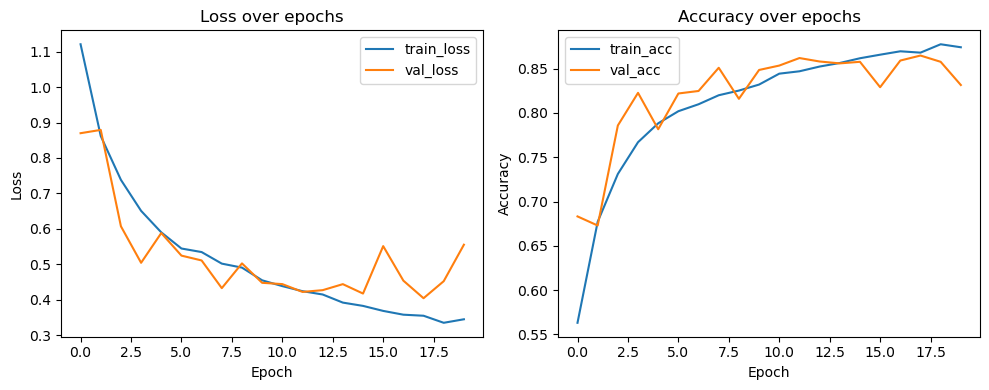

In [8]:
# === CNN Model Definition & Training ===
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os

NUM_CLASSES = 6
IMG_SIZE = (150, 150)
MODEL_PATH = "intel_cnn_best.keras"

# Define a baseline CNN
def build_cnn(input_shape=(150, 150, 3), num_classes=NUM_CLASSES):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # regularisation
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="intel_cnn_baseline")
    return model

model = build_cnn()
model.summary()

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Callbacks: early stopping + best model
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_PATH,
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)

# Train the model
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop, checkpoint],
)

# Plot training history
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss over epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy over epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Confusion matrix shape: (6, 6)


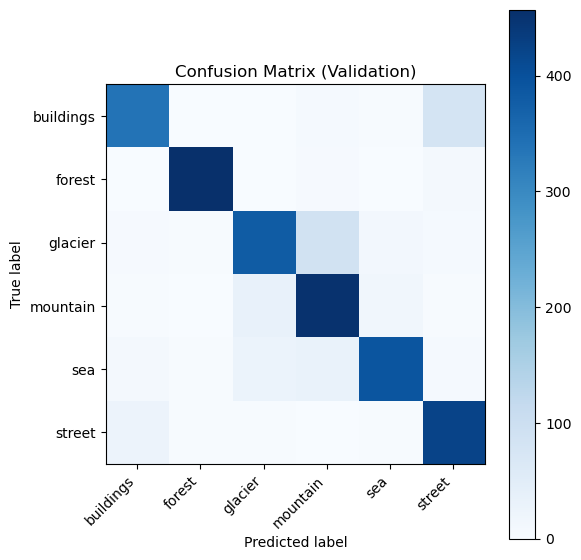

Classification Report:

              precision    recall  f1-score   support

   buildings     0.8895    0.7879    0.8356       429
      forest     0.9807    0.9703    0.9755       471
     glacier     0.8539    0.7708    0.8102       493
    mountain     0.7784    0.8900    0.8304       509
         sea     0.9224    0.8376    0.8779       468
      street     0.8027    0.9297    0.8615       455

    accuracy                         0.8648      2825
   macro avg     0.8712    0.8644    0.8652      2825
weighted avg     0.8699    0.8648    0.8647      2825



In [9]:
# === Evaluation: confusion matrix, classification report ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load best model from training
best_model = tf.keras.models.load_model("intel_cnn_best.keras")

# Get predictions on the validation dataset
y_true = []
y_pred = []

for batch_imgs, batch_labels in val_ds:
    true_ids = np.argmax(batch_labels.numpy(), axis=1)
    preds = best_model.predict(batch_imgs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)

    y_true.extend(true_ids)
    y_pred.extend(pred_ids)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)

# Plot confusion matrix nicely
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, cmap="Blues")

ax.set_xticks(range(len(classes)))
ax.set_yticks(range(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix (Validation)")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Classification report
report = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
)
print("Classification Report:\n")
print(report)


---
## 4. Evaluate Model

The Convolutional Neural Network (CNN) trained on the Intel Image Classification dataset demonstrated strong and stable performance. Meaning for scene recognition, the chosen architecture and preprocessing pipeline were successful. The best model achieved a validation accuracy of 86.48%, it was saved at epoch 18 through early stopping and checkpointing.

Evaluation metrics chosen and shown below ensure a balanced view of model correctness, discrimination, and class performance. 

---

### 4a. Model Evaluation and Interpretation

The CNN model was evaluated using accuracy, precision, recall, F1-score, confusion matrix, and learning curves. Below are descriptions of these metrics followed by results. 

- **Accuracy** measures the overall proportion of correct predictions that the model made (Muller & Guido, 2016). It offers a general indication of performance and it applicable for roughly balanced datasets like this one (OpenAI, 2025). 

- **Precision, Recall, and F1-score** offer a enhanced understanding of the model's performance for each class (Muller & Guido, 2016). Precision quantifies the images predicted to belong to a class were actually correct, recall measures the number of true instances of that class that were successfully identified, and F1-score balances the two (Muller & Guido, 2016; OpenAI, 2025). Combined, they outline the model's ability to distinguish visually similar categories liked mountains and glaciers. 

- **Learning Curves** show the model's convergence and generalisation behaviour. Over successive epochs, the training and validation loss and accuracy were plotted. The loss and convergence smooth decline of both curves suggest the model learned meaningful representations with slight overfitting (Muller & Guido, 2016; OpenAI, 2025). 

- **Confusion Matrix** shows a granular breakdown of model predictions, showing true versus predicted classes. It shows model confusion by visually related categories and is crucial to analyse systematic misclassifications or bias (Muller & Guido, 2016). There was only a minor overlap however, mainly between glacier-mountain, and building-street, confirming the model's robust discriminative capability.

**Performance Overview**:

| **Metric**          | **Value** |
|---------------------|-----------|
| Validation Accuracy | 0.8648    |
| Macro Precision     | 0.8712    |
| Macro Recall        | 0.8644    |
| Macro F1 Score      | 0.8652    |


The models generalisation ability is good, showing minimal overfitting given the minor gap between training and validation accuracy curves (Muller & Guido, 2016). Smooth convergence was seen in the learning curves with improvement in loss and accuracy that was consistent up to the stopping point, meaning effective model optimisation (OpenAI, 2025). 

**Class-Level Analysis**:

There was slightly varied performance across categories (OpenAI, 2025):

- Forest (Precision 0.98, Recall 0.97) - very strong, probably due to clear texture and green colour cues.
- Sea (Precision 0.92, Recall 0.83) - also strong, likely due to distinct blue tone ranges.
- Buildings (Precision 0.89, Recall 0.79) - the average recall implies some confusion with street scenes containing urban features.
- Glacier (Precision 0.85, Recall 0.77) - common misclassifications as mountain, showed shared image patterns.
- Mountain (Precision 0.77, Recall 0.89) - well distringuished even though some overlap with glacier images.
- Street (Precision 0.80, Recall 0.93) - has a high recall but some false positives from buildings category. 

The confusion matrix reaffirmed these relationships with most confusions being between glacier-mountain and buildings-street classes which can be expected given visual similarity. 

**Interpretation**: 

Overall it can be said that there was balanced precision and recall across all six categories exhibited by the CNN, with a robust capacity to learn hierarchical spatial features from natural imagery (OpenAI, 2025). The model is effective and fair across classes given the good macro-average F1-score of 0.865. 

For future improvements, generalisation might be enhanced data augmentation (Muller & Guido, 2016; OpenAI, 2025). More so, transfer learning with pretrained network to might better feature richness (OpenAI, 2025). Finally, using learning rate scheduling and batch normalisation could stabalise deeper architectures (Muller & Guido, 2016).

To conclude, the analytical goals established prior have been met by the CNN model as it successfully classifies natural scene images with good reliability and validation accuracy, and shows well-balanced class level performance. 

---

### 4b. Model Retraining Justification

Retraining was deemed unnecessary given the learning curves showed stable convergence and minimal signs of overfitting and underfitting. The model reached optimal performance for its current architecture and dataset size given both training and validation losses plateaued smoothly and validation accuracy stabalised above 86% (OpenAI, 2025). Ergo, retraining would have increased overfitting risk and only offered marginal benefit (Muller & Guido, 2016). 

---

## 5a. Refer to the PDF titled 'ST10203070_PDAN8412_POE_Report' to view the report.

---

### References

Bansal, P., 2018. Intel Image Classification. [Online] 
Available at: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/code
[Accessed 31 October 2025].

Muller, A. C. & Guido, S., 2016. Introduction to Machine Learning with Python. 1st ed. Sebastopol: O'Reilly Media.

OpenAI, 2025. Open AI ChatGPT5. [Online] 
Available at: https://chatgpt.com/share/690b4bf3-015c-8004-83d6-c89971dfbe4f
[Accessed 01 November 2025].


